# Creating a global map using HealpixML from a single target image

## Authors & Contributors

### Authors

- Jean-Marc Delouis, LOPS - Laboratoire d'Oceanographie Physique et Spatiale UMR 6523 CNRS-IFREMER-IRD-Univ.Brest,
- Tina Odaka, Laboratoire d'Oceanographie Physique et Spatiale UMR 6523 CNRS-IFREMER-IRD-Univ.Brest,

## Context

This notebook demonstrates the use of HealpixML packages to synthesize new maps from an initial target map. The synthesized maps retain the same Scattering Covariance (SC) statistics as the target map. The target map is here a Large Scale Structure simulation of weak lensing, from the CosmoGrid data set (Kacprzak et al. 2023; Fluri et al. 2022); utilized in this example is identical to the one in Mousset et al. (submitted 2024), and the synthesis method is nearly the same.

### The method

The idea is to calculate the SC statistic $\Phi(d)$ for the target map $d$ and generate a new map $u$ that minimizes the following loss:
$L = \sum_k{\frac{(\Phi(d)_k - \Phi(u)_k)^{2}}{\sigma_k^{2}}}$

Here, $k$ denotes the $k^{th}$ SC coefficients, and $\sigma_k^{2}$ represents the variance of $\Phi(d)_k$ across the target map. Specifically, $\Phi(d)_k$ values are obtained by integrating over the entire domain wavelet maps, while $\sigma_k^{2}$ values correspond to the variance within this domain.

The map $u$ is initially set to random Gaussian noise, and the final result is obtained by iteratively minimizing $L$ using gradient descent. The resulting map $u$ is then returned.

### For further details on the synthesis domain, please refer to:

Fluri, J., Kacprzak, T., Lucchi, A., et al. 2022, Phys. Rev. D, 105, 083518 

Kacprzak, T., Fluri, J., Schneider, A., Refregier, A., & Stadel, J. 2023, Journal of Cosmology and Astroparticle Physics, 2023, 05 

Mousset, L., Allys E.,  Pric, M. A., . Aumo, J., Delouis, J.-M., Montier, L., McEwen, J. D., Sumitted 2024 Astronomy & Astrophysic

## Installation of required packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import healpixml.scat_cov as sc
import healpixml.Synthesis as synthe

## Convert Data in HEALPix

The above gap-filling method does not take into account that our subject is a sphere. Because we work with full globe data, we need to treat the grid system that conveys the shape of the sphere. To do that, we use one of the Discrete Global Grid Systems (DGGS), HEALPix.

HEALPix stands for Hierarchical Equal Area isoLatitude Pixelation of a sphere. This pixelation produces a subdivision of a spherical surface in which each pixel covers the same surface area as every other pixel. 
![HEALPix](https://healpix.sourceforge.io/images/gorski_f1.jpg)

See [https://healpix.sourceforge.io](https://healpix.sourceforge.io) and/or [the HEALPix Primer](https://healpix.jpl.nasa.gov/pdf/intro.pdf) for more information.

The [healpy tutorial](https://healpy.readthedocs.io/en/latest/tutorial.html#NSIDE-and-ordering) is also a very good starting point to understand more about HEALPix.

### Resolution
The resolution of the grid is expressed by the parameter `Nside`, which defines the number of divisions along the side of a base-resolution pixel that is needed to reach a desired high-resolution partition.

### Ordering Systems

HEALPix supports two pixel ordering systems: `nested` and `ring`.

Detailed explanations of the two pixel ordering systems can be found at [https://healpix.jpl.nasa.gov/html/intronode4.htm](https://healpix.jpl.nasa.gov/html/intronode4.htm).

In our exam

### choose the resolution

we use $nside=64$ in this context to prevent excessive computation.ple we use `nested` 

In [2]:
nside=16

### Get Large Scale Structure data

The target map is here a LSS simulation of weak lensing, from the CosmoGrid data set (Kacprzak et al. 2023; Fluri et al. 2022); 

In [3]:
!wget -O target_map_lss.npy https://github.com/astro-informatics/s2scat/raw/main/notebooks/data/target_map_lss.npy

--2025-03-11 14:03:57--  https://github.com/astro-informatics/s2scat/raw/main/notebooks/data/target_map_lss.npy
Resolving github.com (github.com)... 140.82.121.3
connected. to github.com (github.com)|140.82.121.3|:443... 
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/astro-informatics/s2scat/main/notebooks/data/target_map_lss.npy [following]
--2025-03-11 14:03:58--  https://raw.githubusercontent.com/astro-informatics/s2scat/main/notebooks/data/target_map_lss.npy
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
connected. to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... 
200 OKequest sent, awaiting response... 
Length: 1046656 (1022K) [application/octet-stream]
Saving to: ‘target_map_lss.npy’

target_map_lss.npy  100%[===================>]   1022K  --.-KB/s    in 0.09s   

2025-03-11 14:03:58 (11.1 MB/s) - ‘target_map_lss.npy’ saved [10

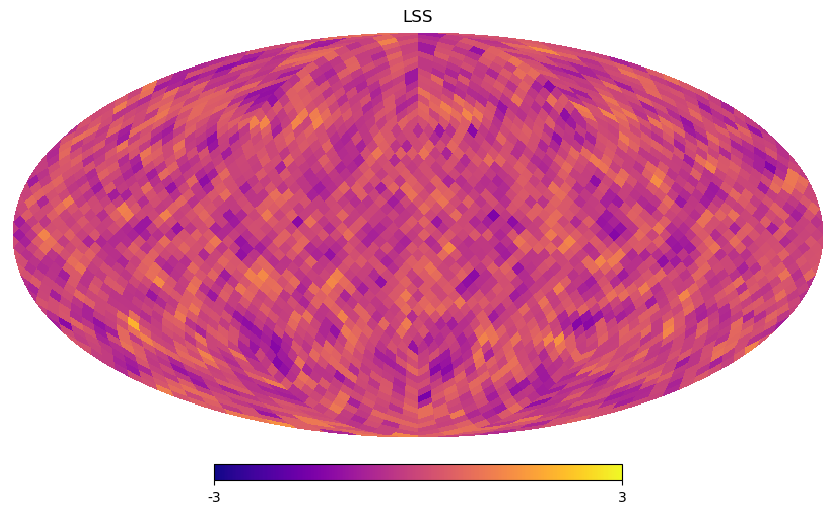

In [4]:
from scipy.interpolate import RegularGridInterpolator

# convert the input data in a nside=128 healpix map
l_nside=128

im = np.load('target_map_lss.npy')
xsize,ysize=im.shape

# Define the new row and column to be added to prepare the interpolation
new_row = im[0:1,:]  # A new row with N elements (the other longitude)
new_column = np.concatenate([im[:,0:1],im[-2:-1,0:1]],0)  # A new column with N+1 elements to add previous latitude

# Add the new row to the array
im = np.vstack([im, new_row])

# Add the new column to the array with the new row

im = np.hstack([im, new_column])

# Create a grid of coordinates corresponding to the array indices
x = np.linspace(0, im.shape[0]-1, im.shape[0])
y = np.linspace(0, im.shape[1]-1, im.shape[1])

# Create an interpolator
interpolator = RegularGridInterpolator((x, y), im)

# List of healpix coordinate to interpol
colatitude,longitude = hp.pix2ang(l_nside,np.arange(12*l_nside**2),nest=True)
coords = np.concatenate([colatitude/np.pi*xsize,longitude/(2*np.pi)*ysize],0).reshape(2,colatitude.shape[0]).T

# Perform the interpolation
heal_im = interpolator(coords)

#reduce the final map to the expected resolution
if nside>128:
    th,ph=hp.pix2ang(nside,np.arange(12*nside**2),nest=True)
    heal_im=hp.get_interp_val(heal_im,th,ph,nest=True)
else:
    heal_im=np.mean(heal_im.reshape(12*nside**2,(l_nside//nside)**2),1)
hp.mollview(heal_im,cmap='plasma',nest=True,title='LSS',min=-3,max=3)

# free memory
del coords
del interpolator
del colatitude
del longitude

### Initialise HealpixML scattering covariance description

In [5]:
scat_op=sc.funct(NORIENT=4,          # define the number of wavelet orientation
                KERNELSZ=5,          #KERNELSZ,  # define the kernel size     
                BACKEND='torch',
                all_type='float32')

/home/jmdeloui/miniconda3/envs/py39/lib/python3.9/site-packages/healpixml/backend.py:386: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at /pytorch/aten/src/ATen/SparseCsrTensorImpl.cpp:53.)
  return self.backend.sparse_coo_tensor(indice.T, w, dense_shape).to_sparse_csr().to(self.torch_device)


### Compute the reference statistics

In [6]:
# Compute the reference statistics and store the normalization in *scat_op*
ref = scat_op.eval(heal_im, norm='auto')

# Recompute the coefficients using the stored normalization in *scat_op* (norm='self')
ref, sref = scat_op.eval(heal_im, calc_var=True, norm='self')

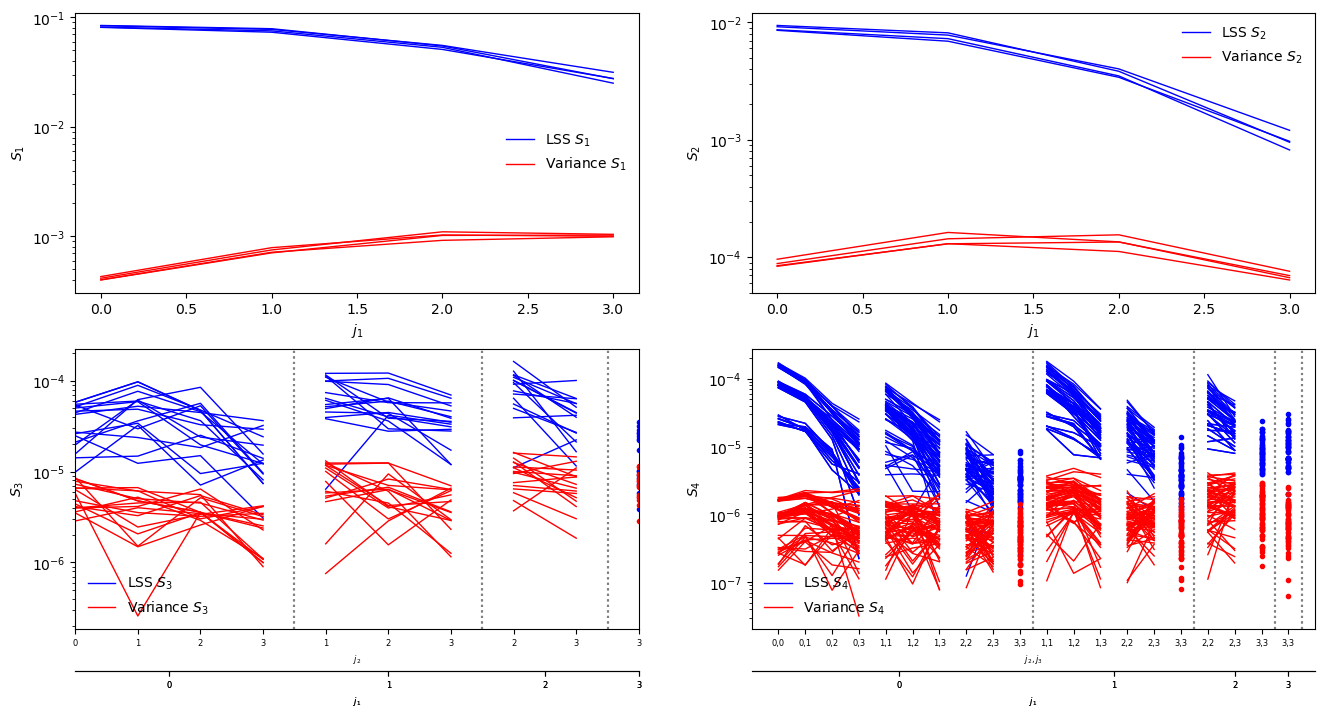

In [7]:
# Plot the coefficients and their variance
ref.plot(name='LSS', color='b')
sref.plot(name='Variance', color='r', hold=False)

# Synthesis of an image using the Scattering Coefficients of a Target (1 to 1)

* Step 1: Define a loss function that will be called at each iteration of the minimization.
* Step 2: Build the synthesis model from the loss. Several loss functions can be declared.
* Step 3: Define the initial image, here a white noise, and execute the optimization of the defined model.
* Step 4: Plot the result.

### Define the loss function

In [8]:
def The_loss(u,scat_operator,args):
    ref  = args[0]
    sref = args[1]

    # compute scattering covariance of the current synthetised map called u
    learn=scat_operator.eval(u,norm='self')

    # make the difference withe the reference coordinates
    loss=scat_operator.reduce_distance(learn,ref,sigma=sref)

    return(loss)

### Build the synthesis model

In [9]:
loss1=synthe.Loss(The_loss,scat_op,ref,sref)

sy = synthe.Synthesis([loss1])

### Run the synthesis

In [10]:
imap=np.random.randn(12*nside**2)*np.std(heal_im)

omap=scat_op.to_numpy(sy.run(imap,
            EVAL_FREQUENCY=100,
            NUM_EPOCHS = 1000))

Total number of loss  1
Itt      0 L=       567 (       567 ) 0.281s 
Itt    100 L=      2.41 (      2.41 ) 12.689s 
Itt    200 L=      1.07 (      1.07 ) 12.629s 
Itt    300 L=     0.704 (     0.704 ) 11.959s 
Itt    400 L=     0.544 (     0.544 ) 12.270s 
Itt    500 L=     0.455 (     0.455 ) 11.961s 
Itt    600 L=     0.399 (     0.399 ) 12.319s 
Itt    700 L=     0.362 (     0.362 ) 12.510s 
Itt    800 L=     0.335 (     0.335 ) 12.680s 
Itt    900 L=     0.314 (     0.314 ) 12.768s 
Itt   1000 L=     0.297 (     0.297 ) 12.669s 
Final Loss  0.29696959257125854


### Plot the results

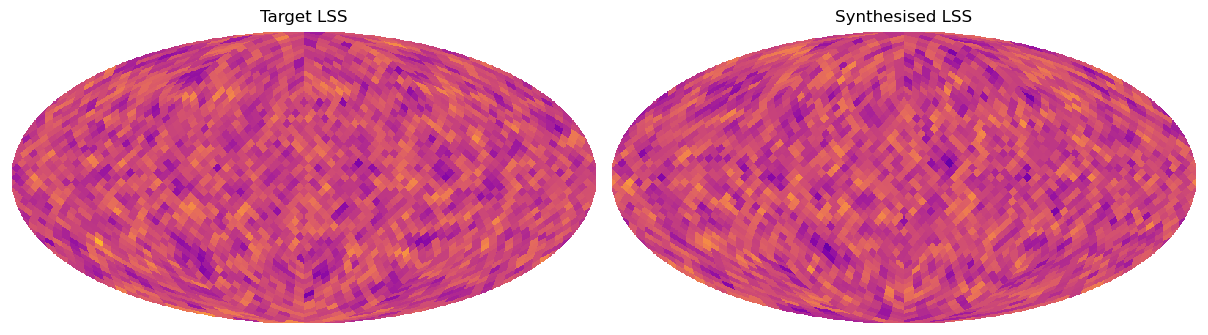

In [11]:
plt.figure(figsize=(12,10))
hp.mollview(heal_im,cmap='plasma',nest=True,title='Target LSS',min=-3,max=3,
            hold=False,sub=(1,2,1),cbar=False)
hp.mollview(omap,cmap='plasma',nest=True,title='Synthesised LSS',min=-3,max=3,
            hold=False,sub=(1,2,2),cbar=False)

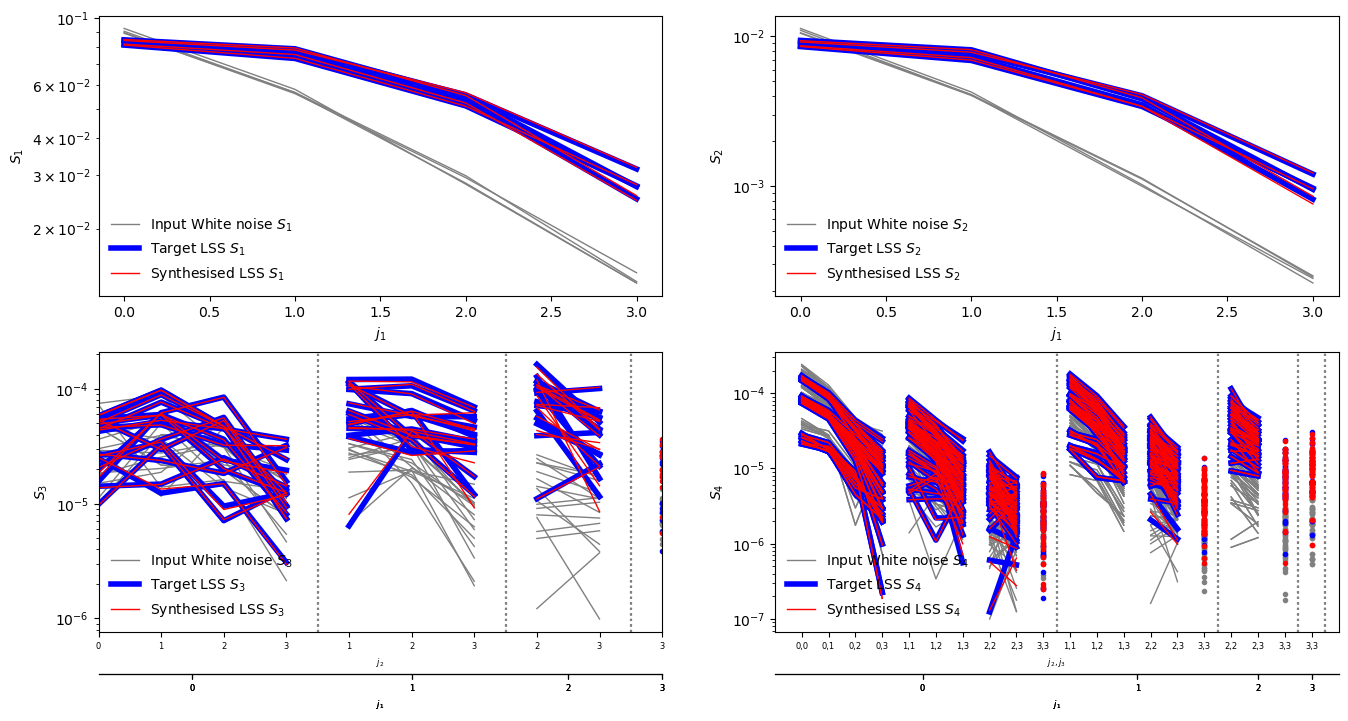

In [12]:
synth=scat_op.eval(omap,norm='self')
inscat=scat_op.eval(imap,norm='self')
inscat.plot(name='Input White noise',color='grey')
ref.plot(name='Target LSS',color='b',lw=4,hold=False)
synth.plot(name='Synthesised LSS',color='r',hold=False)

# Emulate an ensemble (1 to N=4)

Using the previous paradigm, it is possible to synthesize multiple images in such a way that the mean scattering covariance coefficients of the ensemble equal the target data.

In [ ]:
def The_loss_mean(u, scat_operator, args):
    ref  = args[0]
    sref = args[1]

    # Compute the mean scattering covariance of the current synthesized maps called u
    learn = scat_operator.reduce_mean_batch(scat_operator.eval(u, norm='self'))
    
    # Compute the difference with the reference coefficients
    loss = scat_operator.reduce_mean(scat_operator.square((learn - ref) / sref))

    return loss

loss_mean = synthe.Loss(The_loss_mean, scat_op, ref, sref)

sy_mean = synthe.Synthesis([loss_mean])

# Initialize 4 images: Changing this value will generate an ensemble of the specified number of images (here 4).
imap = np.random.randn(4, 12 * nside**2) * np.std(heal_im)

omap = scat_op.to_numpy(sy_mean.run(imap,
                        EVAL_FREQUENCY=100,
                        NUM_EPOCHS=1000))

Total number of loss  1
Itt      0 L=       471 (       471 ) 1.003s 
Itt    100 L=     0.645 (     0.645 ) 44.880s 


In [ ]:
plt.figure(figsize=(12,10))
hp.mollview(heal_im,cmap='plasma',nest=True,title='Target LSS',min=-3,max=3,
            hold=False,sub=(3,2,1),cbar=False)
for k in range(4):
    hp.mollview(omap[k],cmap='plasma',nest=True,title='Synthesised LSS #%d'%(k),min=-3,max=3,
                hold=False,sub=(3,2,3+k),cbar=False)

In [ ]:
plt.figure(figsize=(12,8))
ref.plot(name='Target LSS',color='grey',norm=True,lw=4,hold=False)

color=['b','r','orange','pink']
for k in range(4):
    synth=scat_op.eval(omap[k],norm='self')
    synth.plot(name='Synthesised LSS #%d'%(k),color=color[k],hold=False,norm=True)